In [15]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import pandas as pd
from AES import*
from Model.CNN import cnn_classifier
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.stats import mode
from utils.LoadData import load_CW_Source,load_CW_Target
from sklearn.utils import shuffle

**Step 1-2: Establish the Mapping for All Bytes and Identify the Key-Related S-box**

In [16]:
def getBox(num):
    # Initialize mapping matrices
    pk_v_box = np.zeros((256, 256))  # Stores p^k to v mapping
    p_v_box = np.zeros((16, 256))    # Stores p to v mapping
    
    # Process each byte position (0-15)
    for byte in range(16):
        # Load profiling traces (training data)
        profiling_traces, _, _, _, _, _ = load_CW_Source(
            in_file=profiling_Data_path,
            sec=20000,  # Fixed security parameter
            byte=byte
        )
        # Load attack traces and associated data
        X_attack, label_V, p_attack = load_CW_Target(
            in_file=Target_Data_path,
            byte=byte
        )
        
        # Load and configure model
        model = cnn_classifier(input_size=800)
        model.reset_states()
        model_name = f'Source_Model_byte{byte}_D1.h5'
        model.load_weights(model_path + model_name)

        # Shuffle datasets while maintaining correspondence
        X_attack, label_V, p_attack = shuffle(X_attack, label_V, p_attack)

        # Slice datasets to specified size
        X_attack_shuffle = X_attack[:num]
        label_V_shuffle = label_V[:num]
        p_attack_shuffle = p_attack[:num]

        # Data preprocessing pipeline
        # 1. Standardization (zero-mean, unit-variance)
        scaler = preprocessing.StandardScaler()
        profiling_traces = scaler.fit_transform(profiling_traces)
        X_attack_shuffle = scaler.transform(X_attack_shuffle)
        
        # 2. Normalization to [0,1] range
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        profiling_traces = scaler.fit_transform(profiling_traces)
        X_attack_shuffle = scaler.transform(X_attack_shuffle)

        # Generate model predictions
        predictions = model.predict(X_attack_shuffle)

        # Process prediction results
        A = np.squeeze(predictions)  # Remove singleton dimensions
        B = np.squeeze(p_attack_shuffle)
        df = pd.DataFrame({'pred': list(A), 'plaintext': list(B)})

        # Aggregate predictions by plaintext value
        sum_by_plaintext = df.groupby('plaintext')['pred'].sum()

        # Build pk_v_box mapping (byte 0 only)
        if byte == 0:
            for k in range(256):  # All possible key values
                for i in range(256):  # All possible input values
                    if i in sum_by_plaintext:
                        # Xor-based mapping: i^k -> argmax
                        pk_v_box[k, i ^ k] = np.argmax(sum_by_plaintext[i])
                    else:
                        pk_v_box[k, i ^ k] = -1  # Invalid entry

        # Build p_v_box mapping for current byte
        for j in range(256):  # All possible plaintext values
            if j in sum_by_plaintext:
                p_v_box[byte, j] = np.argmax(sum_by_plaintext[j])
            else:
                p_v_box[byte, j] = -1  # Mark missing entries

    return pk_v_box, p_v_box

**Step 3: Identify the Linear Collision Relationship and Establish Subkey Dependencies from \( k_0 \) to \( k_{15} \)**

In [17]:
def getKey_diff(p_v_box):
    """Calculate key differentials from p_v_box mapping
    Args:
        p_v_box: 16x256 mapping matrix [byte_position][plaintext] -> value
    Returns:
        tuple: (k_diff_mode - most frequent differentials, 
                p - candidate key bytes)
    """
    # Initialize result containers
    p = []  # Stores valid key byte candidates
    k_diff_total = np.zeros([256, 16], dtype=int)  # Differential storage
    k_diff_total[:] = -1  # -1 indicates invalid entries

    # Iterate over all possible intermediate values (0-255)
    for a in range(256):
        # Initialize key byte candidate
        pk = np.zeros(16, dtype=int)  # 16-byte key candidate
        
        # Find positions where p_v_box equals current value 'a'
        row_indices, col_indices = np.where(p_v_box == a)
        
        # Construct key candidate from mappings
        for row, col in zip(row_indices, col_indices):
            pk[row] = col  # row=byte position, col=plaintext

        # Store complete candidates (all 16 bytes found)
        if len(pk) == 16:  # Original condition preserves array size check
            p.append(pk)

        # Calculate differentials between first byte and others
        for i in range(16):
            k_diff_total[a][i] = pk[0] ^ pk[i]  # XOR differential
            
    # Calculate mode for each byte position (exclude -1)
    k_diff_mode = np.array([
        # Find most frequent non-negative differential
        mode(col[col != -1]).mode[-1] if np.any(col != -1) else -1
        for col in k_diff_total.T  # Process each column (byte position)
    ])

    return k_diff_mode, p

**Step 4: Construct a Simulated Encryption and Compare \( c \) with \( c_{k0} \)**

In [18]:
# --------------------- S-BOX IMPLEMENTATIONS --------------------- 
def sub_bytes_SM4(state):
    """SM4 S-box substitution (16-byte state)"""
    for i in range(16):
        state[i] = SM4_Sbox[state[i]]  # Use SM4 lookup table

def sub_bytes_SK(state):
    """Skinny S-box substitution (16-byte state)"""
    for i in range(16):
        state[i] = Skinny_Sbox[state[i]]  # Use Skinny lookup table

def sub_bytes_var(state, key, pk_v_box):
    """Custom S-box substitution using precomputed mapping"""
    for i in range(16):
        # Lookup substitution using key-dependent mapping
        state[i] = int(pk_v_box[int(key), state[i]])

# --------------------- CRYPTOGRAPHIC ROUND FUNCTIONS ---------------------
def generate_round_function(name):
    """Factory method for creating round functions with different S-box implementations"""
    def round_function(plaintext, key, pk_v_box=None):
        """
        Generic encryption round function
        Args:
            plaintext: 16-byte input state
            key: 16-byte encryption key
            pk_v_box: Optional mapping table for custom S-box
        Returns:
            16-byte ciphertext state
        """
        # Key schedule generation
        round_keys = np.zeros([176], dtype=int)
        generate_round_keys(key, round_keys)  # External key expansion
        
        # Initialize state
        state = np.array(plaintext)
        
        # Main rounds (9 full rounds)
        for i in range(9):
            # Typical round operations
            shift_rows(state)
            shift_rows(round_keys[i*16:(i+1)*16])  # Key scheduling
            add_round_key(state, round_keys[i*16:(i+1)*16])
            
            # S-box selection logic
            if name == 'SM4':
                sub_bytes_SM4(state)
            elif name == 'Skinny':
                sub_bytes_SK(state)
            elif name == 'Custom':
                sub_bytes_var(state, key[0], pk_v_box)
            
            mix_columns(state)  # Diffusion layer

        # Final round (no MixColumns)
        shift_rows(state)
        shift_rows(round_keys[144:160])
        add_round_key(state, round_keys[144:160])
        
        # Final S-box application
        if name == 'SM4':
            sub_bytes_SM4(state)
        elif name == 'Skinny':
            sub_bytes_SK(state)
        elif name == 'Custom':
            sub_bytes_var(state, key[0], pk_v_box)
        
        # Final key addition
        add_round_key(state, round_keys[160:])
        
        return state
    
    return round_function

# Instantiate specific implementations
round_function_total_SM4 = generate_round_function('SM4')
round_function_total_Skinny = generate_round_function('Skinny')
round_function_total_pk_vbox = generate_round_function('Custom')



In [19]:
def SimuateEncrypt(p, k, k_diff, pk_v_box):
    """Simulate encryption with key differentials
    Args:
        p: Plaintext (16-byte array)
        k: Base key (unused in original implementation)
        k_diff: Key differential array [16 elements]
        pk_v_box: Custom S-box mapping
    Returns:
        List of ciphertexts for all possible first key byte guesses
    """
    total_key = np.zeros([16])  # Initialize 16-byte key
    c = []  # Ciphertext storage
    
    # Try all possible values for first key byte (0-255)
    for gk in range(256):
        # Set first key byte
        total_key[0] = gk  
        
        # Derive other key bytes using differentials
        for i in range(16):
            total_key[i] = gk ^ k_diff[i]  # XOR with differentials
        
        # Encrypt with generated key
        temp = round_function_total_pk_vbox(p, total_key, pk_v_box)
        c.append(temp)
        
    return c

def get_key(c_true, c_guess, k_diff):
    """Recover correct key from ciphertext matches
    Args:
        c_true: Reference ciphertext (correct encryption result)
        c_guess: List of guessed ciphertexts from SimuateEncrypt
        k_diff: Key differential array [16 elements]
    Returns:
        16-byte correct key array
    """
    key_byte0 = 0  # Initialize first key byte
    
    # Find matching ciphertext index
    for i in range(256):
        # Compare complete ciphertext match
        if len(c_guess[i]) == len(c_true) and all(x == y for x, y in zip(c_guess[i], c_true)):
            key_byte0 = i  # Found correct first byte index
            break
    
    # Reconstruct full key using differentials
    key_correct = np.zeros([16], dtype=int)
    for i in range(16):
        key_correct[i] = key_byte0 ^ k_diff[i]  # XOR with differentials
    
    return key_correct

<b> evaluation

In [20]:
def attackForSbox(num,SboxType):
    # Predefined correct key (16 bytes)
    key = [0x3F,0x1C,0x77,0xC5,0xA8,0x6E,0x5A,0xF1,0x19,0xA4,0x07,0x3F,0x51,0xFD,0xAE,0xA7]
    
    # Get key-dependent S-box mappings
    pk_v_box, p_v_box = getBox(num)
    
    # ----- S-box Validation Test -----
    tnum = 0
    # Verify consistency between Skinny_Sbox and generated pk_v_box
    for i in range(256):
        if (SM4_Sbox[i] - pk_v_box[key[0], i]) != 0:
            tnum += 1  # Count mismatched entries
    # print('wrong num',tnum)
    
    # Get key differentials and candidate keys
    k_diff, pk = getKey_diff(p_v_box)
    
    # Random plaintext selection
    random_int = random.randint(0, len(pk))
    try:
        choose_p = pk[random_int]
    except IndexError:
        return 0
    
    # Validate plaintext length
    if len(choose_p) != 16:
        print('error')
        return 0

    # ----- Ground Truth Calculation -----
    # Calculate actual key differentials
    k_diff_true = np.zeros([16], dtype=int)
    for i in range(16):
        k_diff_true[i] = key[0] ^ key[i]  # XOR with first key byte

    # print(k_diff-k_diff_true)

    # Generate reference ciphertext using real encryption
    if(SboxType=='Skinny'):
        c_true = round_function_total_Skinny(choose_p, key)
    else:
        c_true=round_function_total_SM4(choose_p, key)
    
    # Simulate encryption with guessed keys
    c_guess = SimuateEncrypt(choose_p, key, k_diff, pk_v_box)
    
    # Recover key from ciphertext matches
    key_guess = get_key(c_true, c_guess, k_diff)
    
    # Verify key correctness
    flag = 0
    if set(key_guess) == set(key):
        # print("Attack successful, recovered key:", key_guess)
        flag = 1
    return flag

def evaluate_accuracy(attack_range,SboxType):
    """Evaluate the accuracy of attackForSbox function
    Args:
        attack_range: Range of attack numbers to test (e.g., range(2000, 10001, 500))
    
    Returns:
        List of tuples containing (attack_num, accuracy_rate)
    """
    num_trials = 20  # Number of trials per attack number
    
    SR_results = []
    
    # Test each attack number in the range
    for attack_num in attack_range:
        success_count = 0
        
        # Run multiple trials for statistical significance
        for _ in range(num_trials):
            result = attackForSbox(attack_num,SboxType)
            success_count += result
        
        # Calculate success rate
        accuracy = success_count / num_trials
        SR_results.append((attack_num, accuracy))
        
        print(f"Attack Num: {attack_num}, Success Rate: {accuracy:.2f}")
    
    return SR_results

<b>Source Model-Target(SM4-sbox)

In [21]:
# Main parameter initialization
profiling_Data_path='../Dataset/AES_device1/'
Target_Data_path='../Dataset/SM4_device1/'
model_path = '../Model/'

In [23]:
SM4_SR=evaluate_accuracy(range(1000, 5001,500),'SM4')

Attack Num: 1000, Success Rate: 0.0
Attack Num: 1500, Success Rate: 0.1
Attack Num: 2000, Success Rate: 0.15
Attack Num: 2500, Success Rate: 0.4
Attack Num: 3000, Success Rate: 0.85
Attack Num: 3500, Success Rate: 0.9
Attack Num: 4000, Success Rate: 1.0
Attack Num: 4500, Success Rate: 1.0
Attack Num: 5000, Success Rate: 1.0


<b><b>Source Model-Target(Skinny-sbox)

In [ ]:
# Main parameter initialization
profiling_Data_path='../Dataset/AES_device1/'
Target_Data_path='../Dataset/Skinny_device1/'
model_path = '../Model/'

In [ ]:
Skinny_SR=evaluate_accuracy(range(1000, 5001,500),'Skinny')

Attack Num: 1000, Success Rate: 0.0
Attack Num: 1500, Success Rate: 0.1
Attack Num: 2000, Success Rate: 0.1
Attack Num: 2500, Success Rate: 0.35
Attack Num: 3000, Success Rate: 0.75
Attack Num: 3500, Success Rate: 0.8
Attack Num: 4000, Success Rate: 0.8
Attack Num: 4500, Success Rate: 1.0
Attack Num: 5000, Success Rate: 1.0


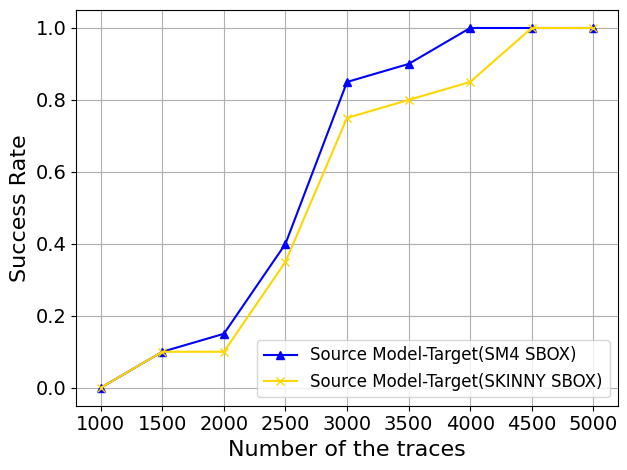

In [26]:
x = np.arange(1000, 5001, 500)
plt.plot(x, [y for _, y in SM4_SR],color='b', marker='^',label='Source Model-Target(SM4 SBOX)')
plt.plot(x, [y for _, y in Skinny_SR],color='gold',marker='x',label='Source Model-Target(SKINNY SBOX)')
plt.grid(True)  

plt.xlabel('Number of the traces', fontsize=16)
plt.ylabel('Success Rate', fontsize=16)
plt.legend(fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
# plt.savefig(d_out+'AES-X_attackACC.pdf')
plt.savefig('AES-X_attackACC.pdf')
plt.show()